# LLM Prefill & Decode: Compute vs Memory Boundness — Corrected Formulas, Intuition, and Plots

This notebook consolidates the corrected equations for **prefill** (encode) and **decode** (per new token) phases of Transformer-based LLM inference, derives **arithmetic intensity vs machine balance** sanity checks, and visualizes **compute time**, **memory time**, and **max(time)** across relevant ranges of sequence length $L$ and batch size $S$.

We follow the convention that **every matmul costs $2mnp$ FLOPs** (multiply + add).

## Parameters (Default Values)

- $S$: concurrent requests at the step (batch size)
- $L$: context length (prefill) / past tokens (decode)
- $P = S \cdot L$: "token budget"
- $d$: hidden size
- $r$: FFN expansion ratio ($\approx 4$)
- $n_\ell$: number of Transformer layers
- $\text{dtype}_B$: bytes per element (e.g., 2 for FP16/BF16)
- $\mathcal{F}$: sustained GPU FLOPs/s (e.g., A100-40GB FP16 TC $\approx 3.12\times 10^{14}$)
- $BW$: device memory bandwidth in B/s (e.g., A100-40GB $\approx 1.555\times 10^{12}$)
- $c_{\text{act}}$: activation I/O multiplier (use 12)

We also define the **machine balance** $\beta = \mathcal{F} / BW$ (FLOPs per byte).

## Corrected Formulas

### Prefill (encode) — per step
**Compute FLOPs (per layer, across $S$ requests):**

$$(8+4r) L d^2 + 4 L^2 d$$

**Compute time:**

$$T_{\text{prefill}}^{\text{compute}}(S,L) = \frac{n_\ell S \big((8+4r) L d^2 + 4 L^2 d\big)}{\mathcal{F}}$$

**Memory bytes:**

$$\text{Bytes}_{\text{prefill}} = n_\ell \Big((4+2r) d^2 + (2+c_{\text{act}}) S L d \Big) \, \text{dtype}_B$$

**Memory time:**

$$T_{\text{prefill}}^{\text{memory}}(S,L) = \frac{n_\ell \Big((4+2r) d^2 + (2+c_{\text{act}}) S L d \Big) \, \text{dtype}_B}{BW}$$

---

### Decode (per new token) — per step
**Compute FLOPs (per layer, across $S$ requests):**

$$(8+4r) d^2 + 4 L d$$

**Compute time per token:**

$$T_{\text{token}}^{\text{compute}}(S,L) = \frac{n_\ell S \big((8+4r) d^2 + 4 L d\big)}{\mathcal{F}}$$

**Memory bytes (per token, across all $S$ and layers):**

$$\text{Bytes}_{\text{token}} = n_\ell \Big((4+2r) d^2 + (2SL + (2+c_{\text{act}})S) d \Big) \, \text{dtype}_B$$

**Memory time per token:**

$$T_{\text{token}}^{\text{memory}}(S,L) = \frac{n_\ell \Big((4+2r) d^2 + (2SL + (2+c_{\text{act}})S) d \Big) \, \text{dtype}_B}{BW}$$

## Intuition & Insights

- **Prefill** grows $O(L^2)$ due to attention; tends compute-bound for large $L$.
- **Decode** grows linearly in $L$; KV-cache reads dominate memory, so decode tends memory-bound beyond short contexts.
- $S$ scales both compute and memory similarly, so $L$ mainly drives boundness.
- **Arithmetic Intensity (AI)** $= \text{FLOPs}/\text{Bytes}$: if $AI > \beta$ → compute-bound; else memory-bound.
- For A100-40GB, $\beta \approx 200$ FLOPs/byte.

In [ ]:
import numpy as np, matplotlib.pyplot as plt
F=3.12e14; BW=1.555e12; dtype_B=2; c_act=12
presets={"7B": {"d":4096,"n_layers":32,"r":4}, "70B": {"d":8192,"n_layers":80,"r":4}}
def t_prefill_compute(S,L,d,nL,r): return nL*S*((8+4*r)*L*d**2+4*L**2*d)/F
def t_prefill_memory(S,L,d,nL,r): return nL*(((4+2*r)*d**2)+(2+c_act)*S*L*d)*dtype_B/BW
def t_decode_compute(S,L,d,nL,r): return nL*S*((8+4*r)*d**2+4*L*d)/F
def t_decode_memory(S,L,d,nL,r): return nL*(((4+2*r)*d**2)+(2*S*L+(2+c_act)*S)*d)*dtype_B/BW
beta=F/BW; beta

200.64308681672026

## Prefill Plots

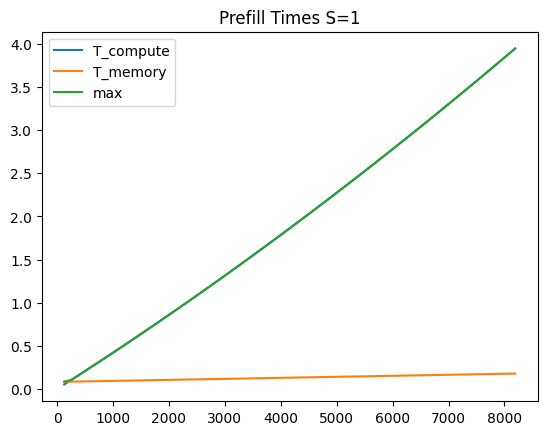

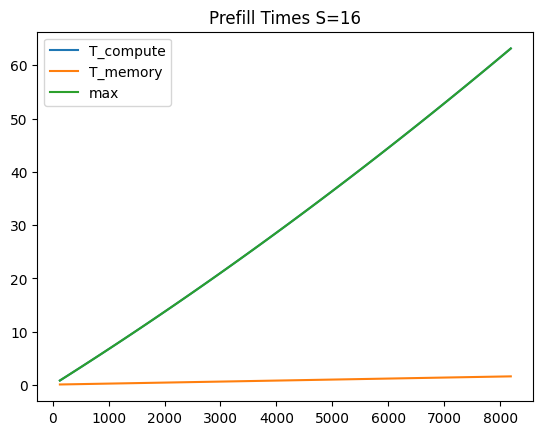

In [ ]:
cfg=presets['70B']; d,nL,r=cfg['d'],cfg['n_layers'],cfg['r']
L=np.arange(128,8192+1,128)
for S in [1,16]:
 Tc=[t_prefill_compute(S,l,d,nL,r) for l in L]
 Tm=[t_prefill_memory(S,l,d,nL,r) for l in L]
 plt.plot(L,Tc,label='T_compute'); plt.plot(L,Tm,label='T_memory'); plt.plot(L,np.maximum(Tc,Tm),label='max')
 plt.title(f'Prefill Times S={S}'); plt.legend(); plt.show()

## Decode Plots

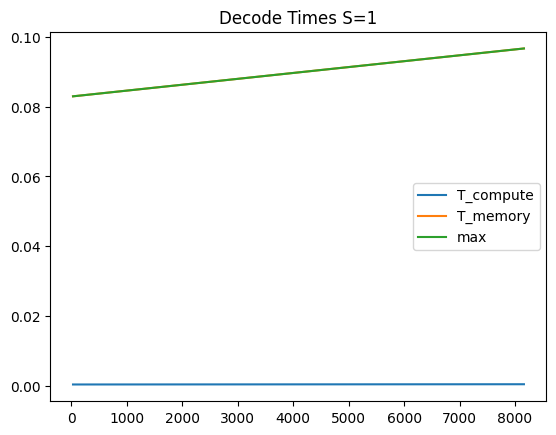

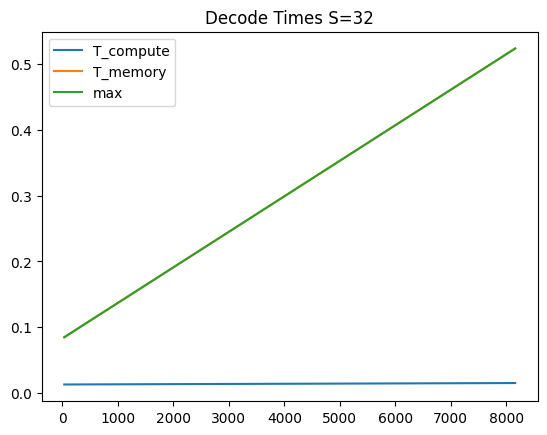

In [ ]:
cfg=presets['70B']; d,nL,r=cfg['d'],cfg['n_layers'],cfg['r']
L=np.arange(32,8192+1,64)
for S in [1,32]:
 Tc=[t_decode_compute(S,l,d,nL,r) for l in L]
 Tm=[t_decode_memory(S,l,d,nL,r) for l in L]
 plt.plot(L,Tc,label='T_compute'); plt.plot(L,Tm,label='T_memory'); plt.plot(L,np.maximum(Tc,Tm),label='max')
 plt.title(f'Decode Times S={S}'); plt.legend(); plt.show()

In [ ]:
# === Prefill: 3D surfaces for T_compute(S,L), T_memory(S,L), and max(T) ===
# Uses plotly.graph_objs as requested. Generates three separate 3D figures.
# Corrected formulas (2mnp FLOPs):
# T_compute = n_layers * S * ((8+4r)*L*d^2 + 4*L^2*d) / F
# T_memory  = n_layers * (((4+2r)*d^2) + (2+c_act)*S*L*d) * dtype_B / BW

import numpy as np
import plotly.graph_objs as go

# ---- Hardware & model defaults (A100-40GB FP16 + 70B-like model) ----
F = 3.12e14          # sustained FLOPs/s (adjust to measured)
BW = 1.555e12        # sustained Bytes/s memory bandwidth (adjust if profiled)
dtype_B = 2          # bytes per element (FP16/BF16)
c_act = 12           # activation I/O multiplier (matches your ipynb assumption)

d = 8192             # hidden size
n_layers = 80        # number of layers
r = 4                # FFN expansion

# ---- Grids (edit to taste) ----
S_vals = np.array([1, 2, 4, 8, 16, 32, 64, 128], dtype=float)     # batch sizes
L_vals = np.arange(128, 8192 + 1, 128, dtype=float)               # context lengths

Sg = S_vals[None, :]              # shape (1, Ns)
Lg = L_vals[:, None]              # shape (Nl, 1)

# ---- Prefill times ----
T_compute = (n_layers * Sg * ((8 + 4*r) * Lg * (d**2) + 4 * (Lg**2) * d)) / F
T_memory  = (n_layers * (((4 + 2*r) * (d**2)) + (2 + c_act) * Sg * Lg * d) * dtype_B) / BW
T_compute_over_T_memory     = np.divide(T_compute, T_memory)
T_max = np.maximum(T_compute, T_memory)
# ---- Boundary (where compute ≈ memory) ----
eps = 0.05  # 5% relative tolerance
den = np.maximum(T_compute, T_memory)
boundary_mask = np.abs(T_compute - T_memory) / np.where(den == 0, 1, den) <= eps
b_i, b_j = np.where(boundary_mask)
b_L = L_vals[b_i]
b_S = S_vals[b_j]
b_Zc = T_compute[b_i, b_j]  # use compute surface for z placement

def make_surface(z, title, zlabel):
    fig = go.Figure(data=[
        go.Surface(x=S_vals, y=L_vals, z=z, showscale=True),
        go.Scatter3d(x=b_S, y=b_L, z=b_Zc, mode="markers",
                     marker=dict(size=3, opacity=0.8))
    ])
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="S (batch size)",
            yaxis_title="L (tokens)",
            zaxis_title=zlabel,
        ),
        margin=dict(l=0, r=0, t=40, b=0)
    )
    fig.show()

make_surface(T_compute, "Prefill — T_compute(S,L)", "Time per prefill step (s)")
make_surface(T_memory,  "Prefill — T_memory(S,L)",  "Time per prefill step (s)")
make_surface(T_compute_over_T_memory,     "Prefill — T_compute/T_memory(S,L)", "Time per prefill step (s)")


In [4]:
# === Decode: 3D surfaces per token for T_compute(S,L), T_memory(S,L), and max(T) ===
# Corrected formulas (2mnp FLOPs):
# T_compute/token = n_layers * S * ((8+4r)*d^2 + 4*L*d) / F
# T_memory/token  = n_layers * (((4+2r)*d^2) + (2*S*L + (2+c_act)*S)*d) * dtype_B / BW

import numpy as np
import plotly.graph_objs as go

# ---- Hardware & model defaults (A100-40GB FP16 + 70B-like model) ----
F = 3.12e14
BW = 1.555e12
dtype_B = 2
c_act = 12

d = 8192
n_layers = 80
r = 4

# ---- Grids (edit to taste) ----
S_vals = np.arange(1, 1001, 50, dtype=float)     # batch sizes
L_vals = np.arange(32, 8192 * 2 + 1, 64, dtype=float)                 # past-length tokens

Sg = S_vals[None, :]              # (1, Ns)
Lg = L_vals[:, None]              # (Nl, 1)

# ---- Decode times per token ----
T_compute = (n_layers * Sg * ((8 + 4*r) * (d**2) + 4 * Lg * d)) / F
T_memory  = (n_layers * (((4 + 2*r) * (d**2)) + (2 * Sg * Lg + (2 + c_act) * Sg) * d) * dtype_B) / BW
T_compute_over_T_memory     = np.divide(T_compute, T_memory)
T_max = np.maximum(T_compute, T_memory)

# ---- Boundary (where compute ≈ memory) ----
eps = 0.05
den = np.maximum(T_compute, T_memory)
boundary_mask = np.abs(T_compute - T_memory) / np.where(den == 0, 1, den) <= eps
b_i, b_j = np.where(boundary_mask)
b_L = L_vals[b_i]
b_S = S_vals[b_j]
b_Zc = T_compute[b_i, b_j]

def make_surface(z, title, zlabel):
    fig = go.Figure(data=[
        go.Surface(x=S_vals, y=L_vals, z=z, showscale=True),
        go.Scatter3d(x=b_S, y=b_L, z=b_Zc, mode="markers",
                     marker=dict(size=3, opacity=0.8))
    ])
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="S (batch size)",
            yaxis_title="L (past length, tokens)",
            zaxis_title=zlabel,
        ),
        margin=dict(l=0, r=0, t=40, b=0)
    )
    fig.show()

make_surface(T_compute, "Decode — T_compute(S,L) per token", "Time per token (s)")
make_surface(T_memory,  "Decode — T_memory(S,L) per token",  "Time per token (s)")
# make_surface(T_compute_over_T_memory, "Decode — T_compute/T_memory(S,L) per token", "Time per token (s)")
make_surface(T_max, "Decode — max(T) per token", "Time per token (s)")